# 1. Explore Data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import time
import json
import matplotlib.pyplot as plt
from co_helper import *
import datetime
import torch.optim as optim

%matplotlib inline

### Import Feature Data

Take a quick look into our feature dataset

In [2]:
df = pd.read_csv("./data/features/co19-data.csv")
df.info()
df.sort_values(by="PROVINCE_STATE_NAME").head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959926 entries, 0 to 959925
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   PEOPLE_POSITIVE_CASES_COUNT      959926 non-null  int64  
 1   COUNTY_NAME                      895706 non-null  object 
 2   PROVINCE_STATE_NAME              899542 non-null  object 
 3   REPORT_DATE                      959926 non-null  object 
 4   CONTINENT_NAME                   959926 non-null  object 
 5   DATA_SOURCE_NAME                 959926 non-null  object 
 6   PEOPLE_DEATH_NEW_COUNT           959926 non-null  int64  
 7   COUNTY_FIPS_NUMBER               880910 non-null  float64
 8   COUNTRY_ALPHA_3_CODE             959926 non-null  object 
 9   COUNTRY_SHORT_NAME               959926 non-null  object 
 10  COUNTRY_ALPHA_2_CODE             959630 non-null  object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  959926 non-null  int64  
 12  PE

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
132785,8560,Montgomery,Alabama,2020-09-17,America,New York Times,0,1101.0,USA,United States,US,14,170
237211,400,Macon,Alabama,2020-08-24,America,New York Times,0,1087.0,USA,United States,US,5,17
237212,0,Macon,Alabama,2020-03-09,America,New York Times,0,1087.0,USA,United States,US,0,0
237213,466,Macon,Alabama,2020-09-17,America,New York Times,0,1087.0,USA,United States,US,0,19
237214,40,Macon,Alabama,2020-05-03,America,New York Times,0,1087.0,USA,United States,US,2,2
132192,958,Limestone,Alabama,2020-07-23,America,New York Times,0,1083.0,USA,United States,US,18,8
132193,377,Monroe,Alabama,2020-07-23,America,New York Times,0,1099.0,USA,United States,US,18,4
132194,5499,Montgomery,Alabama,2020-07-23,America,New York Times,3,1101.0,USA,United States,US,102,133
132195,357,Randolph,Alabama,2020-07-23,America,New York Times,0,1111.0,USA,United States,US,10,11
132196,249,Washington,Alabama,2020-07-23,America,New York Times,0,1129.0,USA,United States,US,11,9


__Feature Details__:

* Numerical: 
    * PEOPLE_POSITIVE_CASES_COUNT (numerical) -  Total positive cases
    * PEOPLE_POSITIVE_NEW_CASES_COUNT (numerical) - Daily new positive cases
    * PEOPLE_DEATH_COUNT (numerical) - Total deaths
    * PEOPLE_DEATH_NEW_COUNT (numerical) - Daily new deaths counts
* Categorical:
    * REPORT_DATE (datetime/categorical) - "2020-07-23", extract categorical date encodings
    * COUNTRY_SHORT_NAME (categorical) - "United States"
    * COUNTRY_ALPHA_3_CODE (categorical) - "USA"
    * COUNTRY_ALPHA_2_CODE (categorical) - "US"
    * CONTINENT_NAME (categorical) - "America", column may not needed upon exploration
    * PROVINCE_STATE_NAME (categorical) - "Alabama"
    * COUNTY_NAME (categorical) - "Montgomery"
    * COUNTY_FIPS_NUMBER (categorical) - numerical value of COUNTY_NAME
    * DATA_SOURCE_NAME (categorical) - "New York Times" may not need upon exploration
    
    
For the purpose of this study, I will extract only the US state rows. To do that, I am going to select the `COUNTRY_SHORT_NAME` column and filter `United States`.

In [3]:
# Extract just United States and save to 'us'
us = df.loc[df.COUNTRY_SHORT_NAME == 'United States']

### Import Target Dataset

Now, a sample of target data. Each csv file is daily updates on info regarding "reopening" during this time in US states. 

For our purpose, we will only extract columns needed for target (and some features)

In [4]:
# Sample target data 
target_samp = pd.read_csv('./data/targets/0504.csv')
target_samp.info()
target_samp.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   state_abbreviation  51 non-null     object
 1   status              51 non-null     object
 2   state               51 non-null     object
 3   date_details        51 non-null     object
 4   status_details      32 non-null     object
 5   external_link       50 non-null     object
 6   reopened            36 non-null     object
 7   reopening_soon      5 non-null      object
 8   population          51 non-null     int64 
dtypes: int64(1), object(8)
memory usage: 3.7+ KB


,state_abbreviation,status,state,date_details,status_details,external_link,reopened,reopening_soon,population
0,AL,reopening,Alabama,Stay at home began on April 4 and expired on A...,"Gov. Kay Ivey, a Republican, allowed the state...",https://www.al.com/news/2020/04/gov-kay-ivey-p...,"Outdoor and recreation - Beaches, Retail and b...",NaN,4903185
1,AK,reopening,Alaska,Stay at home in effect since March 28.,"Gov. Mike Dunleavy, a Republican, eased restri...",https://www.adn.com/alaska-news/2020/04/25/wha...,"Food and drink - Restaurant dining, Retail and...",NaN,731545
2,AZ,shutdown-restricted,Arizona,Stay at home in effect since March 31 and set ...,"Gov. Doug Ducey, a Republican, extended the st...",https://www.azcentral.com/story/news/local/ari...,Retail and beauty - Retail stores open to curb...,Retail and beauty - Retail stores open to in-p...,7278717
3,AR,soon,Arkansas,"No stay-at-home order statewide, but other res...","Gov. Asa Hutchinson, a Republican, announced t...",https://www.baxterbulletin.com/story/news/loca...,Outdoor and recreation - State park camping; Gyms,"Retail and beauty - Hair salons, barbershops, ...",3017804
4,CA,shutdown-restricted,California,Stay at home in effect since March 19.,California was the first state in the nation t...,https://www.nytimes.com/2020/04/29/us/californ...,NaN,NaN,39512223


We can see that most columns are unnecessary for our case, except for:

__Target data:__
* `state`
* `status` - `reopened`, `reopening`, `reversing`, `pausing` (convert them to ranks)
* `date_details` - Don't need this column for training purpose, but want to assess the first `closed` date referenced in the very first target data (`may 5th`)

__Extra Feature data__:
* `opened_outdoor_recreation`
* `opened_food_and_drink`
* `opened_retail`
* `opened_houses_of_worship`
* `opened_personal_care`
* `opened_entertainment`
* `population` (normalize)


Before we start assessing, manipulating and merging two data sources, I will use a method in the `co_helper` module, `get_numerical`, to count all listed items in each of columns starting with `opened` and return a new target dataset that sums those values.



In [5]:
# Target data file path
file_path = './data/targets/'

# Column lists from target dataset
ycols = ['state', 'status',  'date_details', 'population']
xcol = 'opened'

# Use the helper module to create a new target dataframe for weekly updates
data_y = pd.concat(get_numerical(file_path, xcol, ycols), axis=0)

Next, I want to quickly assess when the first `closed` dates were in the first target data. I am going to use a function in my helper module, `convert_datestr`, to extract all date references in each of `date_details` column values and convert them into dates. Then, I will assess which date to cut off in our feature dataset, if necessary.

In [6]:
# Define month dictionary to convert 'date_details' column to first closed dates(if any)
date_dict = {"March":'3', "April": '4', "May": '5', "June":'6'}

# Create a dictionary that included datetime converted 'date_details' column
day1 = convert_datestr(date_dict, target_samp, 'date_details')


start_day = sorted(day1.loc[day1.date_details!='No Date', 
                                 'date_details'].unique())
start_day[-1], start_day[0]


('4-7-2020', '3-19-2020')

In [7]:
# Check start date in feature dataset
us.sort_values(by='REPORT_DATE')['REPORT_DATE'].iloc[:5]

63583     2020-01-21
280877    2020-01-21
280876    2020-01-21
280875    2020-01-21
629920    2020-01-21
Name: REPORT_DATE, dtype: object

## EXPLAIN HERE

In [8]:
# Get dates starting from April 1st
us = us[us.REPORT_DATE >= '2020-04-01']
us.info()
us.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 663607 entries, 64011 to 959925
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   PEOPLE_POSITIVE_CASES_COUNT      663607 non-null  int64  
 1   COUNTY_NAME                      663607 non-null  object 
 2   PROVINCE_STATE_NAME              663607 non-null  object 
 3   REPORT_DATE                      663607 non-null  object 
 4   CONTINENT_NAME                   663607 non-null  object 
 5   DATA_SOURCE_NAME                 663607 non-null  object 
 6   PEOPLE_DEATH_NEW_COUNT           663607 non-null  int64  
 7   COUNTY_FIPS_NUMBER               652645 non-null  float64
 8   COUNTRY_ALPHA_3_CODE             663607 non-null  object 
 9   COUNTRY_SHORT_NAME               663607 non-null  object 
 10  COUNTRY_ALPHA_2_CODE             663607 non-null  object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  663607 non-null  int64  
 12

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
64011,160,Ozaukee,Wisconsin,2020-05-30,America,New York Times,0,55089.0,USA,United States,US,1,11
64014,1480,Ozaukee,Wisconsin,2020-09-29,America,New York Times,0,55089.0,USA,United States,US,30,19
64015,95,Ozaukee,Wisconsin,2020-05-06,America,New York Times,0,55089.0,USA,United States,US,0,9
64017,2471,Barrow,Georgia,2020-10-17,America,New York Times,3,13013.0,USA,United States,US,18,50
64018,1250,Barrow,Georgia,2020-08-07,America,New York Times,0,13013.0,USA,United States,US,36,32


# 3. Convert Data Types and Scale

1. Rename columns (simplify)
2. Convert date column values to datetime
3. Standardize continuous value inputs in feature dataset (all `case_counts` and `population`), so that each column values will have mean of 0 and standard deviation of 1. Save the mean and std in a dictionary for future conversion.

In [9]:
us.columns = us.columns.str.lower()

In [10]:
## 1. Rename columns

x_cols = us.columns.map(lambda x: x[x.find('_')+1:] if x.startswith('p') else x)
us.columns = x_cols
print(us.columns)

Index(['positive_cases_count', 'county_name', 'state_name', 'report_date',
       'continent_name', 'data_source_name', 'death_new_count',
       'county_fips_number', 'country_alpha_3_code', 'country_short_name',
       'country_alpha_2_code', 'positive_new_cases_count', 'death_count'],
      dtype='object')


In [11]:
us.rename(columns={'state_name': 'state'}, inplace=True)


In [12]:
us.columns

Index(['positive_cases_count', 'county_name', 'state', 'report_date',
       'continent_name', 'data_source_name', 'death_new_count',
       'county_fips_number', 'country_alpha_3_code', 'country_short_name',
       'country_alpha_2_code', 'positive_new_cases_count', 'death_count'],
      dtype='object')

In [13]:
## 2. Standardize Continuous Values

# Numerical variables to standardize
num_cols = ['positive_cases_count', 'positive_new_cases_count', 
            'death_count', 'death_new_count']

# Get scaled (by date) numerical column values in the feature dataset
scaled_x, scaled_dict = scale_columns(us.sort_values(by='report_date')
                                    .set_index(['report_date','state'])
                                    .groupby(['report_date', 'state']).shift(0), num_cols)

scaled_x.head()


positive_cases_count county_name continent_name  \
report_date state                                                           
2020-04-01  North Dakota               -0.1692      Kidder        America   
            Maryland                   -0.1668       Cecil        America   
            Maryland                   -0.1692    Allegany        America   
            Maine                      -0.1689    Franklin        America   
            Vermont                    -0.1670    Franklin        America   

                         data_source_name  death_new_count  \
report_date state                                            
2020-04-01  North Dakota   New York Times          -0.0607   
            Maryland       New York Times           0.1258   
            Maryland       New York Times          -0.0607   
            Maine          New York Times          -0.0607   
            Vermont        New York Times          -0.0607   

                          county_fips_number country_alpha_3_code  \
report_date state                                                   
2020-04-01  North Dakota             38043.0                  USA   
            Maryland                 24015.0                  USA   
            Maryland                 24001.0                  USA   
            Maine                    23007.0                  USA   
            Vermont                  50011.0                  USA   

                         country_short_name country_alpha_2_code  \
report_date state                                                  
2020-04-01  North Dakota      United States                   US   
            Maryland          United States                   US   
            Maryland          United States                   US   
            Maine             United States                   US   
            Vermont           United States                   US   

                          positive_new_cases_count  death_count  
report_date state                                                
2020-04-01  North Dakota                   -0.1647      -0.0976  
            Maryland                       -0.1378      -0.0952  
            Maryland                       -0.1647      -0.0976  
            Maine                          -0.1647      -0.0976  
            Vermont                        -0.1378      -0.0976

In [14]:
scaled_x.info()
scaled_x.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 663607 entries, ('2020-04-01', 'North Dakota') to ('2020-10-20', 'Michigan')
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   positive_cases_count      663607 non-null  float64
 1   county_name               663607 non-null  object 
 2   continent_name            663607 non-null  object 
 3   data_source_name          663607 non-null  object 
 4   death_new_count           663607 non-null  float64
 5   county_fips_number        652645 non-null  float64
 6   country_alpha_3_code      663607 non-null  object 
 7   country_short_name        663607 non-null  object 
 8   country_alpha_2_code      663607 non-null  object 
 9   positive_new_cases_count  663607 non-null  float64
 10  death_count               663607 non-null  float64
dtypes: float64(5), object(6)
memory usage: 77.6+ MB


positive_cases_count county_name continent_name  \
report_date state                                                           
2020-04-01  North Dakota               -0.1692      Kidder        America   
            Maryland                   -0.1668       Cecil        America   
            Maryland                   -0.1692    Allegany        America   
            Maine                      -0.1689    Franklin        America   
            Vermont                    -0.1670    Franklin        America   

                         data_source_name  death_new_count  \
report_date state                                            
2020-04-01  North Dakota   New York Times          -0.0607   
            Maryland       New York Times           0.1258   
            Maryland       New York Times          -0.0607   
            Maine          New York Times          -0.0607   
            Vermont        New York Times          -0.0607   

                          county_fips_number country_alpha_3_code  \
report_date state                                                   
2020-04-01  North Dakota             38043.0                  USA   
            Maryland                 24015.0                  USA   
            Maryland                 24001.0                  USA   
            Maine                    23007.0                  USA   
            Vermont                  50011.0                  USA   

                         country_short_name country_alpha_2_code  \
report_date state                                                  
2020-04-01  North Dakota      United States                   US   
            Maryland          United States                   US   
            Maryland          United States                   US   
            Maine             United States                   US   
            Vermont           United States                   US   

                          positive_new_cases_count  death_count  
report_date state                                                
2020-04-01  North Dakota                   -0.1647      -0.0976  
            Maryland                       -0.1378      -0.0952  
            Maryland                       -0.1647      -0.0976  
            Maine                          -0.1647      -0.0976  
            Vermont                        -0.1378      -0.0976

### Target Data Transform

In [15]:
data_y.info()
data_y.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1298 entries, (0, 0) to (24, 51)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   total_open    1298 non-null   int64 
 1   state         1298 non-null   object
 2   status        1298 non-null   object
 3   date_details  1298 non-null   object
 4   population    1298 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 56.4+ KB


total_open       state               status  \
0 0           2     Alabama            reopening   
  1           5      Alaska            reopening   
  2           1     Arizona  shutdown-restricted   
  3           2    Arkansas                 soon   
  4           0  California  shutdown-restricted   

                                          date_details  population  
0 0  Stay at home began on April 4 and expired on A...     4903185  
  1             Stay at home in effect since March 28.      731545  
  2  Stay at home in effect since March 31 and set ...     7278717  
  3  No stay-at-home order statewide, but other res...     3017804  
  4             Stay at home in effect since March 19.    39512223

scaled: 
 [-0.2038 -0.2038 -0.2038 ... -0.8012 -0.8012 -0.8012]


<AxesSubplot:xlabel='population'>

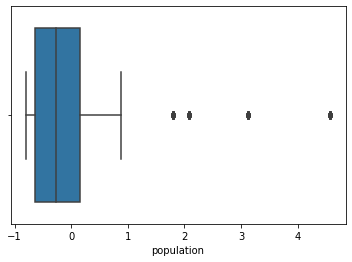

In [16]:
# Get scaled 'population' column from a single target data using co_helper module
scaled_y, scaled_pop = scale_columns(data_y.reset_index(drop=True)
                                     .set_index('state')
                                     .sort_values(by='state'), 
                                     ['population'], 
                                     get_dict=True)

print("scaled: \n", np.hstack(scaled_y.population))

sns.boxplot(scaled_y.population)


In [30]:
"""# Convert date_details column to date values using `convert_datestr` function
data_y = convert_datestr(date_dict, scaled_y, 'date_details')"""

# 3. Dealing with Missing Data

Since we have many entries and columns that are duplicated (daily entries, multiple name correspondence), we can use that to fill in missing ones. But before we fill in missing values, I want to extract just the regions within United States.

#### Feature Data

In [17]:
print("\n---- Null counts after extracting US states only: \n", 
      scaled_x.isnull().sum(), end='\n\n')
#print(us.COUNTRY_SHORT_NAME.value_counts())


---- Null counts after extracting US states only: 
 positive_cases_count            0
county_name                     0
continent_name                  0
data_source_name                0
death_new_count                 0
county_fips_number          10962
country_alpha_3_code            0
country_short_name              0
country_alpha_2_code            0
positive_new_cases_count        0
death_count                     0
dtype: int64



In [18]:
scaled_x.loc[scaled_x.county_fips_number.isnull()].iloc[:7]

positive_cases_count county_name continent_name  \
report_date state                                                             
2020-04-01  North Dakota                 -0.1692     Unknown        America   
            Rhode Island                 -0.1637     Unknown        America   
            Montana                      -0.1692     Unknown        America   
            Hawaii                       -0.1662     Unknown        America   
            Mississippi                  -0.1692     Unknown        America   
            New York                     -0.1692     Unknown        America   
            Virgin Islands               -0.1648     Unknown        America   

                           data_source_name  death_new_count  \
report_date state                                              
2020-04-01  North Dakota     New York Times          -0.0607   
            Rhode Island     New York Times          -0.2471   
            Montana          New York Times          -0.0607   
            Hawaii           New York Times          -0.0607   
            Mississippi      New York Times          -0.0607   
            New York         New York Times           3.8547   
            Virgin Islands   New York Times          -0.0607   

                            county_fips_number country_alpha_3_code  \
report_date state                                                     
2020-04-01  North Dakota                   NaN                  USA   
            Rhode Island                   NaN                  USA   
            Montana                        NaN                  USA   
            Hawaii                         NaN                  USA   
            Mississippi                    NaN                  USA   
            New York                       NaN                  USA   
            Virgin Islands                 NaN                  VIR   

                           country_short_name country_alpha_2_code  \
report_date state                                                    
2020-04-01  North Dakota        United States                   US   
            Rhode Island        United States                   US   
            Montana             United States                   US   
            Hawaii              United States                   US   
            Mississippi         United States                   US   
            New York            United States                   US   
            Virgin Islands      United States                   VI   

                            positive_new_cases_count  death_count  
report_date state                                                  
2020-04-01  North Dakota                     -0.1647      -0.0976  
            Rhode Island                     -0.6352      -0.0807  
            Montana                          -0.1647      -0.0952  
            Hawaii                           -0.0974      -0.0976  
            Mississippi                      -0.1647      -0.0976  
            New York                         -0.1647       0.5990  
            Virgin Islands                   -0.1647      -0.0976

All missing `county_fips_number` have `Unknown` county name. We should fill them by grouping the dataset by state names.

In [19]:
filled = scaled_x.sort_values(by=['state', 'report_date',
                                  'positive_cases_count', 'death_count']).fillna(method='ffill')
#scaled_x.sort_values(by=['state'])['county_fips_number'] = scaled_x.sort_values(by=['state'])['county_fips_number'].fillna(method='bfill')

In [20]:
filled.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 663607 entries, ('2020-04-01', 'Alabama') to ('2020-10-20', 'Wyoming')
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   positive_cases_count      663607 non-null  float64
 1   county_name               663607 non-null  object 
 2   continent_name            663607 non-null  object 
 3   data_source_name          663607 non-null  object 
 4   death_new_count           663607 non-null  float64
 5   county_fips_number        663607 non-null  float64
 6   country_alpha_3_code      663607 non-null  object 
 7   country_short_name        663607 non-null  object 
 8   country_alpha_2_code      663607 non-null  object 
 9   positive_new_cases_count  663607 non-null  float64
 10  death_count               663607 non-null  float64
dtypes: float64(5), object(6)
memory usage: 57.6+ MB


In [21]:
print(np.hstack(scaled_x.columns))
print("\n[US ALPHA3 NAME COUNT]: ", scaled_x.country_alpha_3_code.value_counts()[0])
print("[US ALPHA2 NAME COUNT]: ", scaled_x.country_alpha_2_code.value_counts()[0])
print("[US SHORT NAME COUNT]: ", scaled_x.country_short_name.value_counts()[0])

['positive_cases_count' 'county_name' 'continent_name' 'data_source_name'
 'death_new_count' 'county_fips_number' 'country_alpha_3_code'
 'country_short_name' 'country_alpha_2_code' 'positive_new_cases_count'
 'death_count']

[US ALPHA3 NAME COUNT]:  645946
[US ALPHA2 NAME COUNT]:  645946
[US SHORT NAME COUNT]:  663607


First, checking value counts for US' short name (`United States`) and alpha3/alpha2 codes(`US`, `USA`), there is a mismatch. We need to find out whether there are other countries bounded in `United States`, before running any statistics.

In [22]:
scaled_x = filled.reset_index('state')
[name for name in scaled_x[scaled_x.country_short_name=='United States'].state.unique() 
 if name not in scaled_x[scaled_x.country_alpha_3_code=='USA'].state.unique()]

['Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']

In [26]:
print("State names missing in target dataset:\n", 
      [state for state in scaled_x.state.unique() 
       if state not in scaled_y.index.unique()])

print("State names missing in target dataset:\n", 
      [state for state in scaled_y.index.unique() 
       if state not in scaled_x.state.unique()])

print("\nState name count in feature dataset: ", len(scaled_x.state.unique()))
print("State name count in target dataset: ", len(scaled_y.index.unique()))


State names missing in target dataset:
 ['Guam', 'Northern Mariana Islands', 'Virgin Islands']
State names missing in target dataset:
 []

State name count in feature dataset:  55
State name count in target dataset:  52


The missing country names were Virgin Islands of U.S. territory. For my purpose of this project, I am going to exclude those regions for now. Also, if any of those states pop up throughout all target data, I will exclude them. However, I may return to include them back and re-assess, if must.

In [27]:
islands = ['Puerto Rico', 'Guam', 'Northern Mariana Islands', 'Virgin Islands']

print("before exclusion code/short_name: {}/{}"
      .format(len(scaled_x.country_alpha_3_code.unique()), 
             len(scaled_x.country_short_name.unique())))

scaled_x = scaled_x.reset_index().set_index('state').drop(islands, axis=0)

print("after exclusion code/short_name: {}/{}"
      .format(len(scaled_x.country_alpha_3_code.unique()), 
             len(scaled_x.country_short_name.unique())))

before exclusion code/short_name: 5/1
after exclusion code/short_name: 1/1


In [28]:
# Check value counts for county 
print(len(scaled_x.county_fips_number.unique()))
print(len(scaled_x.county_name.unique()))

# Also check value counts for county names 
print("\n\nCounty Name Value Count: \n", scaled_x.county_name.value_counts())

3132
1847


County Name Value Count: 
 Unknown          9541
Washington       6293
Jefferson        5278
Franklin         5075
Lincoln          4872
                 ... 
Rains             203
Bertie            203
Pointe Coupee     203
Blue Earth        203
Franklin city     203
Name: county_name, Length: 1847, dtype: int64


In [29]:
# Aggregate counties' numerical features by mean
scaled_x = scaled_x.groupby(['report_date', 'state', 'county_fips_number'])[['positive_cases_count', 
                                                                               'positive_new_cases_count', 
                                                                               'death_count', 
                                                                               'death_new_count']].agg(np.mean)


#### Target Data

First, check how many null values exist in each target dataset. If any, must find and fill them in. Also, check number of state names and exclude any of the Virgin Islands in the set.

In [31]:
scaled_y.info()
scaled_y.index.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 1298 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_open    1298 non-null   int64  
 1   status        1298 non-null   object 
 2   date_details  1298 non-null   object 
 3   population    1298 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 50.7+ KB


Tennessee               25
Alaska                  25
Maryland                25
New Hampshire           25
Minnesota               25
Massachusetts           25
Hawaii                  25
Louisiana               25
Connecticut             25
California              25
Delaware                25
Colorado                25
Arizona                 25
North Carolina          25
Idaho                   25
New Jersey              25
Nebraska                25
Iowa                    25
Utah                    25
Illinois                25
Pennsylvania            25
Indiana                 25
Mississippi             25
District of Columbia    25
Alabama                 25
Rhode Island            25
Nevada                  25
South Dakota            25
Texas                   25
Washington              25
Oregon                  25
Missouri                25
Maine                   25
Arkansas                25
West Virginia           25
Montana                 25
Wyoming                 25
N

In [32]:
# Drop Puerto Rico in target dataset
scaled_y.drop('Puerto Rico', axis=0, inplace=True)

The date in our feature dataset starts from beginning of the year, which does not apply entirely for United States. Also, our target dataset does not include up until May 4th, 2020, so we will shorted our feature data to begin from which ever latest date mentioned as "first closed" in the first target dataset, minus 7 days (we need to make up the days lost from shifting 7 times forward, as we'll see in the later steps). Any day before that would be considered "all closed".

[Go to top]()
[2. Dealing with Missing Data]()
<h>

In the target datasets, create a new column of dates similar to `report_date` column in `data_x`, but with dates corresponding to updated date of each target dataset. Then, we can merge the target datasets with feature set using `state` names as well as those date columns.

In [34]:
start_date = datetime.date(2020, 5, 4)
end_date = datetime.date(2020, 10, 19)

nskip = len(scaled_y.index.unique()) # 51 rows to skip

# Get list of dates to fill in
week_dates = [(start_date + datetime.timedelta(n)).strftime('%Y-%m-%d')
             for n in range(0, int((end_date - start_date).days)+7, 7)]*nskip
print(len(week_dates))

# Create a new column 'report_date' then drop 'date_details'
scaled_y['report_date'] = pd.to_datetime(sorted(week_dates)).strftime('%Y-%m-%d')

scaled_y.head()

1275


,total_open,status,date_details,population,report_date
state,,,,,
Alabama,2,reopening,Stay at home began on April 4 and expired on A...,-0.2038,2020-05-04
Alabama,8,pausing,Reopened April 30.,-0.2038,2020-05-04
Alabama,6,reopening,Stay-at-home order expired on April 30.,-0.2038,2020-05-04
Alabama,8,pausing,Reopened April 30.,-0.2038,2020-05-04
Alabama,7,reopening,Stay-at-home order expired on April 30.,-0.2038,2020-05-04


In [35]:
# drop 'date_details'
scaled_y.drop('date_details', axis=1, inplace=True)

### Merge Feature and Target Datasets

* Starting May 4th, 2020: merge in all data from target dataset, filling in that date's data until the following week's data.
* Prior to May 4th, fill in data with None open or backward fill

In [36]:
scaled_x.info()
scaled_x.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 635800 entries, ('2020-04-01', 'Alabama', 1001.0) to ('2020-10-20', 'Wyoming', 56045.0)
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   positive_cases_count      635800 non-null  float64
 1   positive_new_cases_count  635800 non-null  float64
 2   death_count               635800 non-null  float64
 3   death_new_count           635800 non-null  float64
dtypes: float64(4)
memory usage: 22.5+ MB


positive_cases_count  \
report_date state   county_fips_number                         
2020-04-01  Alabama 1001.0                           -0.1677   
                    1003.0                           -0.1658   
                    1005.0                           -0.1692   
                    1007.0                           -0.1687   
                    1009.0                           -0.1684   

                                        positive_new_cases_count  death_count  \
report_date state   county_fips_number                                          
2020-04-01  Alabama 1001.0                               -0.1243      -0.0976   
                    1003.0                               -0.1109      -0.0952   
                    1005.0                               -0.1647      -0.0976   
                    1007.0                               -0.1647      -0.0976   
                    1009.0                               -0.1647      -0.0976   

                                        death_new_count  
report_date state   county_fips_number                   
2020-04-01  Alabama 1001.0                      -0.0607  
                    1003.0                       0.1258  
                    1005.0                      -0.0607  
                    1007.0                      -0.0607  
                    1009.0                      -0.0607

In [37]:
# reset indices in both datasets
merge_y = scaled_y.reset_index().sort_values(by=['report_date','state'])
merge_x = scaled_x.reset_index().sort_values(by=['report_date','state'])

# Get datetime format for date columns before merging the two
merge_y.report_date = merge_y.report_date.astype('datetime64')
merge_x.report_date = merge_x.report_date.astype('datetime64')

In [38]:
# Merge the target onto train, at columns 'report_date' and 'state'
merged = pd.merge(merge_x, merge_y, how='left', on=['report_date', 'state'], copy=False)
merged.head()

,report_date,state,county_fips_number,positive_cases_count,positive_new_cases_count,death_count,death_new_count,total_open,status,population
0,2020-04-01,Alabama,1001.0,-0.1677,-0.1243,-0.0976,-0.0607,NaN,NaN,NaN
1,2020-04-01,Alabama,1003.0,-0.1658,-0.1109,-0.0952,0.1258,NaN,NaN,NaN
2,2020-04-01,Alabama,1005.0,-0.1692,-0.1647,-0.0976,-0.0607,NaN,NaN,NaN
3,2020-04-01,Alabama,1007.0,-0.1687,-0.1647,-0.0976,-0.0607,NaN,NaN,NaN
4,2020-04-01,Alabama,1009.0,-0.1684,-0.1647,-0.0976,-0.0607,NaN,NaN,NaN


In [43]:
# Get month, week features
date_feats = merged.loc[:,'report_date']
merged['month'] = pd.to_datetime(date_feats).dt.month

# Convert month values into string names
merged['month'] = merged['month'].map(lambda x: datetime.date(1900, x, 1).strftime('%B')).values
merged['week'] = pd.to_datetime(date_feats).dt.isocalendar().week.values



In [44]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709528 entries, 0 to 709527
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   report_date               709528 non-null  datetime64[ns]
 1   state                     709528 non-null  object        
 2   county_fips_number        709528 non-null  float64       
 3   positive_cases_count      709528 non-null  float64       
 4   positive_new_cases_count  709528 non-null  float64       
 5   death_count               709528 non-null  float64       
 6   death_new_count           709528 non-null  float64       
 7   total_open                78300 non-null   float64       
 8   status                    78300 non-null   object        
 9   population                78300 non-null   float64       
 10  month                     709528 non-null  object        
 11  week                      709528 non-null  UInt32        
dtypes:

After merging, we need to fill some columns of dates prior to May 4th, in order to avoid losing more data. To make it simple for now, I've just decided to use back fills on those columns.

In [45]:
# Create a dictionary of state's dataframe with all dates filled 
# backward from may 4th, and forward from on. 

train_dict = {}

# Fill nulls by state names
for s in merged.state.unique():
    
    statedf = merged.loc[merged.state==s].sort_values(by='report_date')
    fill = statedf.loc[statedf.report_date <= '2020-05-04'].fillna(method='bfill')
    # first fill forward by week 
    train_dict[s] = fill.loc[fill.report_date < '2020-05-04']
    
    fill = statedf.loc[statedf.report_date >= '2020-05-04'].fillna(method='ffill')
    
    train_dict[s] = pd.concat([train_dict[s], fill], axis=0)    
    


In [46]:
pa = train_dict['Pennsylvania']
pa.info()
pa.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15142 entries, 2239 to 708697
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   report_date               15142 non-null  datetime64[ns]
 1   state                     15142 non-null  object        
 2   county_fips_number        15142 non-null  float64       
 3   positive_cases_count      15142 non-null  float64       
 4   positive_new_cases_count  15142 non-null  float64       
 5   death_count               15142 non-null  float64       
 6   death_new_count           15142 non-null  float64       
 7   total_open                4489 non-null   float64       
 8   status                    4489 non-null   object        
 9   population                4489 non-null   float64       
 10  month                     15142 non-null  object        
 11  week                      15142 non-null  UInt32        
dtypes: UInt32(1), 

,report_date,state,county_fips_number,positive_cases_count,positive_new_cases_count,death_count,death_new_count,total_open,status,population,month,week
708650,2020-10-20,Pennsylvania,42039.0,-0.1106,-0.0706,-0.0903,-0.0607,16.0,reopened,0.8874,October,43
708649,2020-10-20,Pennsylvania,42037.0,-0.0183,-0.1109,-0.0012,0.1258,16.0,reopened,0.8874,October,43
708648,2020-10-20,Pennsylvania,42035.0,-0.1336,-0.1512,-0.0831,-0.0607,16.0,reopened,0.8874,October,43
708654,2020-10-20,Pennsylvania,42047.0,-0.1521,-0.0974,-0.0928,-0.0607,16.0,reopened,0.8874,October,43
708697,2020-10-20,Pennsylvania,42133.0,0.7080,0.8437,0.3676,0.3122,16.0,reopened,0.8874,October,43


For our timeseries prediction, we should manipulate the data a little bit, so that individual sequences in each batch input will be `n` consecutive days.

Our current dataset holds different sequences of state's info, so we need to group by states first, then elongate each row into specified number of sequence days.

In [47]:
# Save last 7 days

# Create a dictionary of individual data by state
state_x = {}
state_y = {}

for name, df_ in train_dict.items():

    df_ = train_dict[name].set_index(['county_fips_number', 'report_date']).sort_values(by=['county_fips_number', 'report_date'])

    x_ = df_.drop('status', axis=1).groupby('county_fips_number').shift(0)
    y_ = df_.groupby('county_fips_number')[['status']].shift(0)
    
    state_x[name] = x_.copy()
    state_y[name] = y_.copy()

    for ii in range(1,7):
        
        state_x[name] = pd.concat([state_x[name], x_.shift(-ii)], axis=1)
        state_y[name] = pd.concat([state_y[name], y_.shift(ii)], axis=1)

    state_x[name] = state_x[name].iloc[:-6]
    state_y[name] = state_y[name].iloc[6:]
    
X = pd.concat(state_x, axis=0)
y = pd.concat(state_y, axis=0)


In [48]:

y.info()
y.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 709222 entries, ('Alabama', 1001.0, Timestamp('2020-04-07 00:00:00')) to ('Wyoming', 56045.0, Timestamp('2020-10-20 00:00:00'))
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   status  337917 non-null  object
 1   status  337869 non-null  object
 2   status  337821 non-null  object
 3   status  337773 non-null  object
 4   status  337725 non-null  object
 5   status  337677 non-null  object
 6   status  337629 non-null  object
dtypes: object(7)
memory usage: 41.4+ MB


status     status     status  \
        county_fips_number report_date                                    
Alabama 1001.0             2020-04-07   reopening  reopening  reopening   
                           2020-04-08   reopening  reopening  reopening   
                           2020-04-09   reopening  reopening  reopening   
                           2020-04-10   reopening  reopening  reopening   
                           2020-04-11   reopening  reopening  reopening   

                                           status     status     status  \
        county_fips_number report_date                                    
Alabama 1001.0             2020-04-07   reopening  reopening  reopening   
                           2020-04-08   reopening  reopening  reopening   
                           2020-04-09   reopening  reopening  reopening   
                           2020-04-10   reopening  reopening  reopening   
                           2020-04-11   reopening  reopening  reopening   

                                           status  
        county_fips_number report_date             
Alabama 1001.0             2020-04-07   reopening  
                           2020-04-08   reopening  
                           2020-04-09   reopening  
                           2020-04-10   reopening  
                           2020-04-11   reopening

In [61]:
X.head()

state  positive_cases_count  \
        county_fips_number report_date                                  
Alabama 1001.0             2020-04-01   Alabama               -0.1677   
                           2020-04-02   Alabama               -0.1677   
                           2020-04-03   Alabama               -0.1674   
                           2020-04-04   Alabama               -0.1674   
                           2020-04-05   Alabama               -0.1674   

                                        positive_new_cases_count  death_count  \
        county_fips_number report_date                                          
Alabama 1001.0             2020-04-01                    -0.1243      -0.0976   
                           2020-04-02                    -0.1647      -0.0976   
                           2020-04-03                    -0.1378      -0.0976   
                           2020-04-04                    -0.1647      -0.0976   
                           2020-04-05                    -0.1647      -0.0976   

                                        death_new_count total_open  \
        county_fips_number report_date                               
Alabama 1001.0             2020-04-01           -0.0607        2.0   
                           2020-04-02           -0.0607        2.0   
                           2020-04-03           -0.0607        2.0   
                           2020-04-04           -0.0607        2.0   
                           2020-04-05           -0.0607        2.0   

                                        population  month  week    state  ...  \
        county_fips_number report_date                                    ...   
Alabama 1001.0             2020-04-01      -0.2038  April    14  Alabama  ...   
                           2020-04-02      -0.2038  April    14  Alabama  ...   
                           2020-04-03      -0.2038  April    14  Alabama  ...   
                           2020-04-04      -0.2038  April    14  Alabama  ...   
                           2020-04-05      -0.2038  April    14  Alabama  ...   

                                        week    state  positive_cases_count  \
        county_fips_number report_date                                        
Alabama 1001.0             2020-04-01     15  Alabama               -0.1674   
                           2020-04-02     15  Alabama               -0.1674   
                           2020-04-03     15  Alabama               -0.1667   
                           2020-04-04     15  Alabama               -0.1667   
                           2020-04-05     15  Alabama               -0.1664   

                                        positive_new_cases_count  death_count  \
        county_fips_number report_date                                          
Alabama 1001.0             2020-04-01                    -0.1647      -0.0952   
                           2020-04-02                    -0.1647      -0.0952   
                           2020-04-03                    -0.0974      -0.0952   
                           2020-04-04                    -0.1647      -0.0952   
                           2020-04-05                    -0.1378      -0.0952   

                                        death_new_count total_open  \
        county_fips_number report_date                               
Alabama 1001.0             2020-04-01           -0.0607        2.0   
                           2020-04-02           -0.0607        2.0   
                           2020-04-03           -0.0607        2.0   
                           2020-04-04           -0.0607        2.0   
                           2020-04-05           -0.0607        2.0   

                                        population  month  week  
        county_fips_number report_date                           
Alabama 1001.0             2020-04-01      -0.2038  April    15  
                           2020-04-02      -0.2038  April    15  
                          

### Get dummy variables

Get dummy variables on all the columns listed inside `category_cols`.

But first, we need to clean up a little bit more on our target column, `status`, which currently holds too many categories that could be grouped together. Best option is to get three target labels: `reopened`, `in risk`, `closed`, ranking from 0 to 2, with 2 being in full "shut-down", restricted mode of a state. Therefore, we can categorize current labels as below:

* `reopened`|`0`  -> encompasses `reopened`, `forward`; "safe to travel outdoors", "dining in", "gyms open", "salons open", "enclosed entertainment settings potential", "OK to work in office settings", etc.

* `in risk`|`1`  -> encompasses `reopening`, `pausing`, `regional`, `soon`; anything in between "all OK to open" and "all closed".

* `closed`|`2`  -> encompasses `reversing`, `shutdown-restricted`; "all closed", "in danger", "stay home", "no gyms".

[COVID-19 United States Reopen and Shut Down Status by State](https://github.com/rearc-data/nyt-states-reopen-status-covid-19)

In [49]:
status_d = {0: ['reopened', 'forward'],
            1: ['reopening', 'pausing', 'regional', 'soon'],
            2: ['reversing', 'shutdown-restricted']}

mask = 1

y = y.status.applymap(lambda x: mask-1 if x in status_d[mask-1] 
                                                   else (mask+1 if x in status_d[mask+1]
                                                         else mask))


In [62]:
X_raw = X.reset_index([0, 'county_fips_number'])
X_raw.drop('level_0', axis=1, inplace=True)

In [51]:
# Reset index to match indices of X_raw when splitting
#y.reset_index([0, 'county_fips_number'], inplace=True)

Now to dummies. 

Use `get_dummy` method in the `co_helper` module to create dummies for categorical variables.


In [68]:
category_cols = ['state', 'county_fips_number', 'month', 'week', 'total_open']

# Get dummies for train portion 
features = get_dummy(X_raw, category_cols)


### Train Test Split and Data Loaders

* Train, test split (0.8/0.2)
* validation split from train set (0.2)
* Convert to tensors using Pytorch transformers
* Get dataloaders using Pytorch
    - each feature inputs are 7 consecutive days
    - each output will be single value (`reopened`, `in risk` or `closed`) of following day
    - select batch size

In [74]:
# Split train, val and test data
train_X, train_y = features.iloc[:int(len(features)*.8)].values, y.iloc[:int(len(y)*.8)].values
val_X, val_y = train_X[int(len(train_X)*.8):], train_y[int(len(train_y)*.8):]
test_X, test_y = features.iloc[int(len(features)*.8):].values, y.iloc[int(len(y)*.8):].values


In [75]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(567377, 3573) (567377, 7)
(113476, 3573) (113476, 7)
(141845, 3573) (141845, 7)


In [76]:
# Specify batch size and sequence length
batch_size = 64
"""
# Get data loaders for train, validation and test sets
trainloader = get_dataloader(train_X, train_y, batch_size, shuffled=True)
validloader = get_dataloader(val_X, val_y, batch_size, shuffled=True)
testloader = get_dataloader(test_X, test_y, batch_size, shuffled=True)
"""
data_dict = {'train': [train_X, train_y], 
             'val': [val_X, val_y], 
             'test': [test_X, test_y]}
# Return Tensor type DataLoader
datasets = {x: TensorDataset(torch.from_numpy(data_dict[x][0]), torch.from_numpy(data_dict[x][1]))
          for x in data_dict.keys()}
data_loader = {x: DataLoader(datasets[x], shuffle=True, batch_size=batch_size) 
               for x in data_dict.keys()}

In [80]:
sample = iter(data_loader['train'])
x, y = sample.next()
print(y)
print(x.shape, y.shape)
len(data_loader['train'].dataset)

tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        

567377

# Build Neural Network Model (RNN, LSTM)

I will be defining the architecture of my Recurrent Neural Network, which uses Long-Short Term Memory Module of Pytorch. The network will do the following:

* Takes in input features along with any other parameters specified for the module.
* Layers are defined
    - embedding layer
    - lstm layers
* Forward processing
    - 
* Output